In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
X_train = pd.read_csv('../../data/X_train.csv', index_col=0)
X_test = pd.read_csv('../../data/X_test.csv', index_col=0)
y_train = pd.read_csv('../../data/y_train.csv', index_col=0)
y_test = pd.read_csv('../../data/y_test.csv', index_col=0)

In [3]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df = train_df.drop(columns = ['id', 'coordinates'])
test_df = pd.concat([X_test, y_test], axis=1)
test_df = test_df.drop(columns=['id', 'coordinates'])

In [4]:
#create a 'new_construction' feature
train_df['new_construction'] = (train_df['yr_built']>2009) | (train_df['yr_renovated']>2009)
test_df['new_construction'] = (test_df['yr_built']> 2009) |(test_df['yr_renovated']>2009)

In [5]:
numeric = train_df.select_dtypes(include="number")
numeric = numeric.drop(columns=['yr_built', 'yr_renovated'])
train_df = train_df.drop(columns=['yr_built', 'yr_renovated'])
numeric_cols = numeric.columns

In [6]:
categorical = train_df.select_dtypes(exclude="number")
category_cols = categorical.columns

In [7]:
train_df.shape

(16197, 18)

In [8]:
train_df['new_construction'].value_counts()

False    15172
True      1025
Name: new_construction, dtype: int64

In [9]:
Q1 = train_df.quantile(0.05)
Q3 = train_df.quantile(0.95)
IQR = Q3 - Q1
train_df = train_df[~((train_df < (Q1-1.5*IQR)) | (train_df> (Q3 + 1.5*IQR))).any(axis=1)]

train_df.shape

(15658, 18)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15658 entries, 6405 to 15795
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bedrooms                   15658 non-null  int64  
 1   bathrooms                  15658 non-null  float64
 2   sqft_living                15658 non-null  int64  
 3   sqft_lot                   15658 non-null  int64  
 4   floors                     15658 non-null  float64
 5   condition                  15658 non-null  object 
 6   grade                      15658 non-null  int64  
 7   sqft_above                 15658 non-null  int64  
 8   sqft_basement              15658 non-null  float64
 9   sqft_living15              15658 non-null  int64  
 10  sqft_lot15                 15658 non-null  int64  
 11  bedrooms_bathrooms         15658 non-null  float64
 12  sqft_lot_sqft_living       15658 non-null  float64
 13  sqft_living_sqft_living15  15658 non-null  

# Standarization

In [11]:
# plt.figure(figsize = (10, 10))
# sns.pairplot(train_df)

Log transform right skewed variables

In [12]:
def log_transform(df, column): 
    '''
    Input: 
    df = DataFrame
    column = column name as string
    
    Output: 
    log of values in column
    '''
    df[column] = np.log(df[column])

In [13]:
log_transform(train_df, 'price')
log_transform(test_df, 'price')

In [14]:
log_transform(train_df, 'sqft_living_bedrooms')
log_transform(test_df, 'sqft_living_bedrooms')

In [15]:
log_transform(train_df, 'bedrooms_bathrooms')
log_transform(test_df, 'bedrooms_bathrooms')

Standard Scale

In [16]:
X_train = train_df.drop(columns='price')
y_train = train_df['price']

In [17]:
X_test = test_df.drop(columns='price')
y_test = test_df['price']

In [18]:
#defining columns to be encoded vs scaled
cols_to_scale = list(X_train.select_dtypes(include='number').columns)
cols_to_encode = list(X_train.select_dtypes(exclude='number').columns)

In [19]:
# Instantiate a new scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

In [20]:
#scale numeric columns
scaler.fit(X_train[cols_to_scale])
scaled_columns = scaler.transform(X_train[cols_to_scale])


#encode categorial columns
ohe.fit(X_train[cols_to_encode])
encoded_columns = ohe.transform(X_train[cols_to_encode])

In [21]:
#create dataframe with column names
scaled_columns = pd.DataFrame(scaled_columns, columns=cols_to_scale)

In [22]:
encoded_columns = pd.DataFrame(encoded_columns, columns=(ohe.get_feature_names()))

In [23]:
#Concatenate processed columns together
X_train_scaled = pd.concat([scaled_columns, encoded_columns], axis=1)


In [24]:
#concatentate with y_train to include target
train_df_scaled = pd.concat([X_train_scaled, y_train], axis=1)
train_df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19950 entries, 0 to 21596
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bedrooms                   15658 non-null  float64
 1   bathrooms                  15658 non-null  float64
 2   sqft_living                15658 non-null  float64
 3   sqft_lot                   15658 non-null  float64
 4   floors                     15658 non-null  float64
 5   grade                      15658 non-null  float64
 6   sqft_above                 15658 non-null  float64
 7   sqft_basement              15658 non-null  float64
 8   sqft_living15              15658 non-null  float64
 9   sqft_lot15                 15658 non-null  float64
 10  bedrooms_bathrooms         15658 non-null  float64
 11  sqft_lot_sqft_living       15658 non-null  float64
 12  sqft_living_sqft_living15  15658 non-null  float64
 13  sqft_living_bedrooms       15658 non-null  flo

## Model with tranformed data

Simple models: 

In [30]:
formula = 'price ~ sqft_living + grade'

model = ols(formula=formula, data=train_df_scaled).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.03792
Date:                Tue, 05 Oct 2021   Prob (F-statistic):              0.963
Time:                        21:05:42   Log-Likelihood:                -8592.4
No. Observations:               11366   AIC:                         1.719e+04
Df Residuals:                   11363   BIC:                         1.721e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      13.0226      0.005   2693.778      0.000      13.013      13.032
sqft_living    -0.0006      0.007     -0.083      0.934      -0.015       0.014
grade          -0.0008      0.007     -0.111      0.911      -0.015       0.013
==============================================================================
Omnibus:                      158.109   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.542
Skew:                           0.278   Prob(JB):                     6.85e-37
Kurtosis:                       3.208   Cond. No.                         2.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

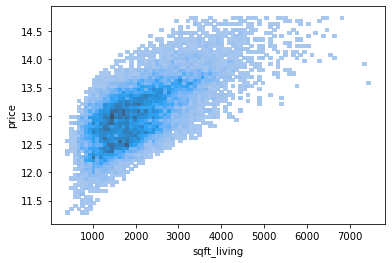

In [26]:
sns.histplot(train_df, x=train_df['sqft_living'], y=train_df['price'])

In [29]:
formula = 'price ~ grade'

model = ols(formula=formula, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                 1.401e+04
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        21:05:18   Log-Likelihood:                -6760.3
No. Observations:               15658   AIC:                         1.352e+04
Df Residuals:                   15656   BIC:                         1.354e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.6633      0.020    526.022      0.000      10.624      10.703
grade          0.3110      0.003    118.367      0.000       0.306       0.316
==============================================================================
Omnibus:                       61.456   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.077
Skew:                           0.153   Prob(JB):                     3.31e-14
Kurtosis:                       3.038   Cond. No.                         53.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
train_df.corr()[['price']].sort_values(by='price', ascending=False)

,price
price,1.000000
grade,0.687218
sqft_living,0.677174
sqft_living15,0.611918
sqft_above,0.576399
sqft_living_bedrooms,0.570207
bathrooms,0.528932
bedrooms,0.342214
floors,0.303031
sqft_basement,0.297911
